1) методы обнаружения объектов, вычитание фона(Background Subtraction Methods)\
2) методы Meanshift and Camshift  для отслеживания объектов на видео \
3) концепция оптического потока(optical flow), методы Lucas-Kanade и Gunner Farneback

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image

In [2]:
cv2.__version__

'4.5.1'

# 1) Захват, открытие и сохранение видео

### Захват видео с веб-камеры

In [74]:
cap = cv2.VideoCapture(0) #Захват видео с вебкамеры


while(True): #Создаем бесконечный цикл
   
    # Получаем кадр за кадром
    ret, frame = cap.read()

    # Смена цветового формата 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Отображаем результат 
    cv2.imshow('frame',gray)
    
    #Прерывание бесконечного цикла по нажатию кнопки на клавиатуре
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# После завершекния цикла "отпускаем" вебкамеру 
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.5.2) /tmp/pip-req-build-eirhwqtr/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


### Захват видео из файла

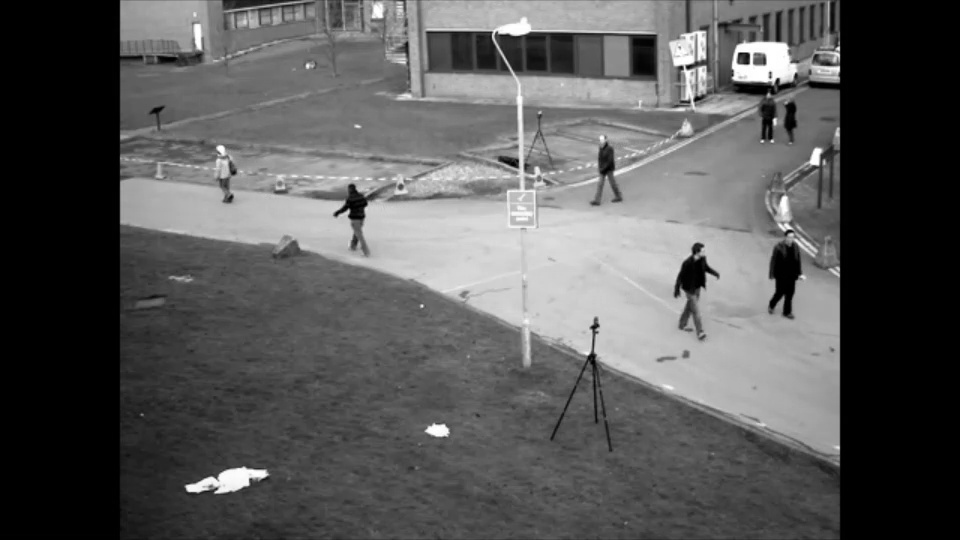

In [ ]:
cap = cv2.VideoCapture('video/test_video_3_1.mp4')#Захват видео из файла

cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,10)

display_handle=display(None, display_id=True)

while(True): #Создаем бесконечный цикл
   
    # Получаем кадр за кадром
    ret, frame = cap.read()
  
    #Проверяем не кончилось ли наше видео
    if not ret:
        break
        
    # Смена цветового формата 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Отображаем результат 
    #cv2.imshow('frame',gray)
    
    _, frame = cv2.imencode('.jpg', gray)
    display_handle.update(Image(data=frame.tobytes()))
    
    #Прерывание бесконечного цикла по нажатию кнопки на клавиатуре
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# После завершекния цикла "отпускаем" вебкамеру и закрываем все окна 
cap.release()
display_handle.update(None)

### Захват и сохранение видео в файл

In [7]:
cap = cv2.VideoCapture(0)

# Определяем кодек и создаем объект VideoWriter 
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.mp4',fourcc, 20.0, (640,480))

while True:
    ret, frame = cap.read()
    if ret==True:
        #Переворачиваем видео слева на право
        frame = cv2.flip(frame,1)

        # записываем перевернутое видео
        out.write(frame)

        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

## 2) Методы вычитания фона

<img src="pic/BG.png">

## Вычитание фона методом MOG(Mixture of Gaussans).
### Адаптивная модель смеси (Гауссиан)

Алгоритм сегментации фона / переднего плана на основе Гауссовой смеси(MOG).
Для каждого пикселя ${x_0, y_0}$ известна последовательность значений за время t: 
$${X_1, ..., X_t} = {I(x_0, y_0, i):1 ≤ i ≤ t}$$

<img src="pic/im10.png">

a) Две диаграммы одного и того же пикселя с разницей 2 минуты. \
b) Бимодальное распределение пикселя обусловленное колебанием воды. \
c) еще одно бимодальное распределение обусловленное мерцанием монитора.

Суть метода заключается в том что создается модель изображения с камеры, каждый пиксель которой характеризуется смесью смесью взвешенных нормальных распределений, таким образом вероятность наблюдаемого значения пикселя равно:
$$P(X_{t}) = \sum_{i=1}^K \omega_{i,t} * \eta(X_{t},\mu_{i,t},E_{i,t})$$
где $K$ - количество распределений, \
$\omega_{i,t}$ - вес Гауссианы(который пропорционален количеству данных принадлежащих i-й Гауссиане),\
$\mu_{i,t}$ - среднее значение i-й Гауссианы,\
$E_{i,t}$ - матрица ковариации  i-й Гауссианы в смеси, \
$\eta$ - функция плотности вероятности нормального распределения  
В алгоритме MOG используется K в диапозоне от 3 до 5. \
В алгоритме MOG2 это органичение снято.\
В целях оптимизации сложности расчета матрица ковариаии заменена на:

$$E_{i,t} = \sigma_k^2I$$

Мы предпологаем что значения красного, синего и зеленого цвета независимы и имеют одинаковую дисперсию.\
Хотя это конечно не так. Данное предположение позволяет избежать нахождения обратной матрицы ценой некоторой точности.\
Таким образом, распределение недавно наблюдаемых значений каждого пикселя характеризуется с помошью смеси Гаусиан. Новое значение пикселя, как правило, представленно одной из компонент и применяется для обновления модели фона. \
Каждое новое значение пикселя проверяется на попадание в дианозон 2,5 сигмы всех К Гауссиан, соответствуюшая Гауссиана обновляется методом максимального правдоподобия с учетом нового значения. Если совпадений не найдено то наименее вероятное распределение заменяется на новое со средним значением равным текущему значению пикселя и изначально высокой сигмой и небольшим весом.\
Вес для всех К распределений в момент времени t, $\omega_{i,t}$, вычисляется следующим образом:

$$\omega_{i,t}=(1-\alpha)\omega_{i,t-1}+\alphaМ_{k,t}$$

Величина $1/\alpha$ характерихует скорость с которой параметры распределений обновляются, $\omega_{k,t}$ отражает апостериорную вероятность того что данное значение пикселя совпало с k-й моделью которая построена наблюдениями за время от 0 до t.   


Параметры $\mu_{i,t}$ и $\sigma_k^2$ для необновляемых Гауссиан остаются без изменения.\
Для Гауссианы в которую попали новые данные обновляются следующим образом:

$$\mu_{t} = (1-p)\mu_{t-1}+pX_t$$

$$\sigma_t^2=(1-p)\sigma_{t-1}^2+p(X_t-\mu_{t})^T(X_t-\mu_{t})$$

где $p=\alpha\eta(X_t\mid\mu_{k},\sigma_k)$

Существенным преимуществом данного метода является то что когда какой-то объект становится частью фона это не разрушает уже существующую модель фона. Следовательно, когда объект стационарный и давно стал фоно, а затем его что то ненадолго перекрывает информация о нем ни куда не пропадает и может быть быстро возвращена. 

### Вычисление модели фона


Значения пикселей которые принадлежат стационарному фону скорее всего будут принадлежать Гауссианам с низкой дисперсией и большим количеством точек данных. И наоборот, новый объект в кадре скорее всего не попадет в существующие распределения и либо задаст новое либо увеличит дисперсию в существующем. Так-же, движушиеся объекты обладают как правило большей дисперсией.\

Во первых, отсотрируем Гауссианы по параметру $\omega/\sigma$ \

Затем первые В распределений принимаются как модель фона.

$$B=argmin_b(\sum_{k=1}^b\omega>T)$$

где Т это минимальная доля данных которая должна быть рассмотренна как фон.

In [4]:
cap = cv2.VideoCapture('video/videoplayback_1.mp4')
cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,10)
display_handle=display(None, display_id=True)


fgbgMOG = cv2.bgsegm.createBackgroundSubtractorMOG(history=500, # Продолжительность отслеживаемой истории
                                                nmixtures=5, # Количество Гауссиан в смеси
                                                backgroundRatio=0.7, # T-Доля
                                                noiseSigma=0  #Уровень шума
                                                )
while True:
    ret, frame = cap.read()
    if ret==True:
        
        fgmask = fgbgMOG.apply(frame)
        #cv2.imshow('fgmask',fgmask)
        #cv2.imshow('frame',frame )
        _, fgmask = cv2.imencode('.jpg', fgmask)
        display_handle.update(Image(data=fgmask.tobytes()))
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
        
cap.release()   
display_handle.update(None)

None

## MOG2

Это также алгоритм сегментации фона / переднего плана на основе Гауссовой смеси. \
Особенность данного алгоритма в том что для каждого пикселя выбирается оптимальное число Гауссиан(К). Он обеспечивает лучшую адаптивность к изменениям освещения и т. д. 

Добавлена функция определения тени( detectShadows = True). Тени помечаются серым цветом.

In [69]:
cap = cv2.VideoCapture('video/test_video_3_1.mp4')
cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,10)
display_handle=display(None, display_id=True)

fgbgMOG2 = cv2.createBackgroundSubtractorMOG2(history=500,
                                   varThreshold=25, #Расстояние Махаланобиса между вектором пикселя и распределением фона
                                   detectShadows=True
                                   ) 
while True:
    ret, frame = cap.read()
    if ret==True:
        fgmask = fgbgMOG2.apply(frame)
       # cv2.imshow('fgmask',fgmask)
        #cv2.imshow('frame',frame )
        
        _, fgmask = cv2.imencode('.jpg', fgmask)
        display_handle.update(Image(data=fgmask.tobytes()))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
display_handle.update(None)

None

## KNN

Метод дополнен применением алгоритма k ближайших соседей. Считается очень эффективным когда движушиеся объекты занимают малую долю изображения.  

In [56]:
cap = cv2.VideoCapture('video/test_video_3_1.mp4')
cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,10)
display_handle=display(None, display_id=True) 

fgbgKNN = cv2.createBackgroundSubtractorKNN(history=500,
                                            dist2Threshold= 400,
                                            detectShadows=True)
  
while True:
    ret, frame = cap.read()
    if ret==True:
        fgmask = fgbgKNN.apply(frame)
        
       # cv2.imshow('fgmask',fgmask)
       # cv2.imshow('frame',frame )
        
        _, fgmask = cv2.imencode('.jpg', fgmask)
        display_handle.update(Image(data=fgmask.tobytes()))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
        
cap.release()   
display_handle.update(None)

None

## GMG

Этот адаптивный алгоритм сочетает в себе статистическую оценку фона и байесовскую сегментацию. \
Он использует вероятностный алгоритм сегментации фона, который идентифицирует возможные объекты переднего плана с помощью теоремы Байеса. \
 Несколько операций фильтрации, таких как закрытие и открытие, выполняются для удаления нежелательного шума.

In [ ]:
cap = cv2.VideoCapture('video/trafic_video_3_1.mp4')
cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,10)
display_handle=display(None, display_id=True)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

fgbgGMG = cv2.bgsegm.createBackgroundSubtractorGMG(initializationFrames = 120, #количество кадров для инициализации 
                                                   decisionThreshold = 0.8)    
  
while True:
    ret, frame = cap.read()
    if ret==True:
        fgmask = fgbgGMG.apply(frame)
        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel);
       # cv2.imshow('fgmask',fgmask)
        #cv2.imshow('frame',frame )
        
        _, frame = cv2.imencode('.jpg', fgmask)
        display_handle.update(Image(data=fgmask.tobytes()))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
display_handle.update(None)

## Сравнение алгоритмов вычитания фона на основе смеси Гауссиан

In [ ]:
cap = cv2.VideoCapture('video/test_video_3_1.mp4')

cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,10)

#fgbgMOG = cv2.bgsegm.createBackgroundSubtractorMOG()
fgbgMOG2 = cv2.createBackgroundSubtractorMOG2()
fgbgKNN = cv2.createBackgroundSubtractorKNN()
#fgbgGMG = cv2.bgsegm.createBackgroundSubtractorGMG()    

display_handle_MOG2=display(None, display_id=True)
display_handle_KNN=display(None, display_id=True)


while True:
    ret, frame = cap.read()
    if ret==True:
      #  MOG = fgbgMOG.apply(frame)
        MOG2 = fgbgMOG2.apply(frame)
        KNN = fgbgKNN.apply(frame)
       # GMG = fgbgGMG.apply(frame)
      #  GMG_m = cv2.morphologyEx(GMG, cv2.MORPH_OPEN, kernel);
        
      #  cv2.imshow('MOG',MOG)
     #   cv2.imshow('MOG2',MOG2)
     #   cv2.imshow('KNN',KNN)
     #   cv2.imshow('GMG',GMG)
    #    cv2.imshow('GMG_m',GMG_m)
        
        _, MOG2 = cv2.imencode('.jpg', MOG2)
        _, KNN = cv2.imencode('.jpg', KNN)
        display_handle_MOG2.update(Image(data=MOG2.tobytes()))
        display_handle_KNN.update(Image(data=KNN.tobytes()))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
display_handle_MOG2.update(None)
display_handle_KNN.update(None)

In [55]:
cap = cv2.VideoCapture('trafic_video_1.mp4')

fgbgMOG = cv2.bgsegm.createBackgroundSubtractorMOG()
fgbgMOG2 = cv2.createBackgroundSubtractorMOG2()
fgbgKNN = cv2.createBackgroundSubtractorKNN()
fgbgGMG = cv2.bgsegm.createBackgroundSubtractorGMG()    
  

while True:
    ret, frame = cap.read()
    if ret==True:
        MOG = fgbgMOG.apply(frame)
        MOG2 = fgbgMOG2.apply(frame)
        KNN = fgbgKNN.apply(frame)
        GMG = fgbgGMG.apply(frame)
        
        
        cv2.imshow('MOG',MOG)
        cv2.imshow('MOG2',MOG2)
        cv2.imshow('KNN',KNN)
        cv2.imshow('GMG',GMG)
        GMG_m = cv2.morphologyEx(GMG, cv2.MORPH_OPEN, kernel);
        cv2.imshow('GMG_m',GMG_m)

        if cv2.waitKey(60) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

 
 
 # 3)Mетоды Meanshift and Camshift для отслеживания объектов на видео
## Meanshift

<img src="pic/MS.png">

<img src="pic/meanshift_face.gif">

In [58]:
cap = cv2.VideoCapture('video/test_video_2_3.mp4')
cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,10)
display_handle=display(None, display_id=True)

while(True):
    ret, frame = cap.read()
    if ret==True:
        #cv2.imshow('frame',frame)
        _, frame = cv2.imencode('.jpg', frame)
        display_handle.update(Image(data=frame.tobytes()))
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()   
display_handle.update(None)

None

<img src="pic/test_video_snapshot.jpg" width="600" align="center">
<img src="pic/HSV.png" width="600" align="center">

In [61]:
cap = cv2.VideoCapture('video/test_video_2_3.mp4')
cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,30)

display_handle=display(None, display_id=True)

# границы цвета отслеживаемого объекта в формате HSV 
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])

while(True):
    ret, frame = cap.read()
    if ret==True:
        
        #Конвертируем изображение в формат HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        #Вычисляем маску для заданных границ в формате HSV
        mask = cv2.inRange(hsv, lower_blue, upper_blue)
        
       # mask = cv2.resize(mask, (0,0), fx=0.7, fy=0.7) 
       # frame = cv2.resize(frame, (0,0), fx=0.7, fy=0.7) 
        
       # cv2.imshow('mask',mask)
       # cv2.imshow('frame',frame)
        
        _, mask = cv2.imencode('.jpg', mask)
        display_handle.update(Image(data=mask.tobytes()))
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
display_handle.update(None)

None

In [62]:
cap = cv2.VideoCapture('video/test_video_2_3.mp4')
cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,30)

display_handle=display(None, display_id=True)
# задаем параметры окна

r,h,c,w = 300,100,10,125  
track_window = (c,r,w,h)

 # границы цвета отслеживаемого объекта в формате HSV 
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])

# Задаем критерии остановки поиска 
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while(True):
    
    ret, frame = cap.read()
    if ret==True:
        #Конвертируем изображение в формат HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        #Вычисляем маску для заданных границ в формате HSV
        mask = cv2.inRange(hsv, lower_blue, upper_blue)
        # Применяем метод для уточнения позиции объекта после смены кадра
        ret, track_window = cv2.meanShift(mask, track_window, term_crit)
       
        # рисуем рамку
        x,y,w,h = track_window
        frame = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)

       # mask = cv2.resize(mask, (0,0), fx=0.7, fy=0.7) 
       # frame = cv2.resize(frame, (0,0), fx=0.7, fy=0.7) 
        
       # cv2.imshow('frame',frame)
       # cv2.imshow('mask',mask)
        _, frame = cv2.imencode('.jpg', frame)
        display_handle.update(Image(data=frame.tobytes()))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()   
display_handle.update(None)

None


## CamShift

<img src="pic/camshift_face.gif">

In [63]:
cap = cv2.VideoCapture('video/test_video_2_3.mp4')
cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,10)

display_handle=display(None, display_id=True)

# задаем параметры окна
r,h,c,w = 300,10,0,12  
track_window = (c,r,w,h)

 # границы цвета отслеживаемого объекта в формате HSV 
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])

# Задаем критерии остановки поиска 
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while(True):
    
    ret, frame = cap.read()
    if ret==True:
        #Конвертируем изображение в формат HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        #Вычисляем маску для заданных границ в формате HSV
        mask = cv2.inRange(hsv, lower_blue, upper_blue)
        # Применяем метод для уточнения позиции объекта после смены кадра
        ret, track_window = cv2.CamShift(mask, track_window, term_crit)
        # рисуем рамку
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)

        frame = cv2.polylines(frame,[pts],True, 255,2)
        
       # mask = cv2.resize(mask, (0,0), fx=0.7, fy=0.7) 
       # frame = cv2.resize(frame, (0,0), fx=0.7, fy=0.7)
        
        _, frame = cv2.imencode('.jpg', frame)
        display_handle.update(Image(data=frame.tobytes()))
    
        #cv2.imshow('frame',frame)
        #cv2.imshow('mask',mask)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    else:
        break
        
cap.release() 
display_handle.update(None)

None

 
 
 # 4) Kонцепция оптического потока(optical flow), методы Lucas-Kanade и Gunner Farneback

Задача оптического потока это оценка попиксельного движения между двумя последовательными кадрами видео.\
В ходе решения данной задачи вычисляется вектор-сдвига для объекта.\
Главная идея оптического потока это оценка движения обьекта в кадре обусловленное движением самого объекта либо движением камеры.

Пусть I(x,y,t) - интенсивность пикселя (x,y) в момент времени t(кадр номер №t).\
Предположим что смещение объекта не меняет интенсивность пикселей принадлежаших конкретному объекту. Тогда:

$$I(x,y,t)=I(x+\triangle x,y+\triangle y,t+\triangle t)$$

В нашем случае t=1. Необходимо найти вектор движения $(\triangle x,\triangle y)$

<img src="pic/OF.png">

Применяя разложение в ряд Тэйлора уравнение $I(x,y,t)-I(x+\triangle x,y+\triangle y,t+\triangle t)=0$ можно записать в виде:

$$I_x^\prime\upsilon+I_y^\prime\nu=-I_t^\prime\$$

где $\upsilon = \frac{\text{d}x}{\text{d}t}$, $\nu = \frac{\text{d}y}{\text{d}t}$ а $I_x^\prime$ и $I_y^\prime$ это градиенты интенсивности.\
Таким образом мы получаем две неизвестные и одно уравнение.
Для решения данной проблеммы применяются различные методы, в данном докладе освещены основные два.\
Для оптического потока применяются два подхода:
#### 1) Точечный. Вычисления производятся только для некоторых "интерестных" точек.
#### 2) Плотный. Вычисления производятся для для каждого пикселя.


## Точечный Optical Flow

### Lucas-Kanade алгоритм

Данный алгоритм основан на предположении о локальном постоянстве движения. Предполагается что соседние пиксели имеют то же смещение $(\triangle x,\triangle y)$. Данное предположение помогает решить уравнение с двумя неизвестными. 

Возьмем окно фиксированного размера. Пусть $p_i=(x_i, y_i)$ координаты i-го пикселя в выбранном окне из n элементов. Тогда мы можем определить следуюшую систему уравнений:
$$\begin{cases}I^\backprime_x(p_1)\upsilon+I^\backprime_y(p_1)\nu=-I^\backprime_t(p_1)\\I^\backprime_x(p_2)\upsilon+I^\backprime_y(p_2)\nu=-I^\backprime_t(p_2)\\...\\I^\backprime_x(p_n)\upsilon+I^\backprime_y(p_n)\nu=-I^\backprime_t(p_n)\end{cases}$$

Данное уравнение можно решить методом наименьших квадратов.

Алгоритмы оптического потока страдают от резких движений. То есть, если объект от кадра к кадру перемешается больше чем пару пикселе то возникают большие проблеммы с решением системы уравнений. С этим борятся путем создания пирамиды изображений создавая копии каждая следушая из которых в два раза меньше предыдущей.

<img src="https://upload.wikimedia.org/wikipedia/commons/d/da/Pyramide_Image_exemple.png">

Для нахождения "интересных точек" для отслеживания применяется алгоритм Shi-Tomasi.

In [70]:
cap = cv2.VideoCapture('video/videoplayback_1.mp4')
cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,10)

display_handle=display(None, display_id=True)

# Параметры для детектора углов ShiTomasi
feature_params = dict(maxCorners=10, qualityLevel=0.3, minDistance=7, blockSize=7)

# Параметры для алгоритма Lucas-Kanade
lk_params = dict(winSize=(15, 15),
    maxLevel=2,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

# Цвета для интересных точек
color = np.random.randint(0, 255, (10, 3))

# Берем первый кадр и применяем ShiTomasi для нахождения точек 
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, 6)
p0 = cv2.goodFeaturesToTrack(old_gray, **feature_params)

# нулевая маска для рисования треков
mask = np.zeros_like(old_frame)


while True:
    # следующий кадр
    ret, frame = cap.read()
    if not ret:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Расчитываем  Optical Flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
     
    # Выбираем активные точки
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    # Рисуем точти и треки
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
        
        
    img = cv2.add(frame, mask)
    #cv2.imshow("frame", img)
    
    _, frame = cv2.imencode('.jpg', img)
    display_handle.update(Image(data=frame.tobytes()))
    
    k = cv2.waitKey(25) & 0xFF
    if k == 27:
        break
        
    # обновляем предыдущий кадр и точки
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
        
cap.release()
display_handle.update(None)

None

## Dense Optical Flow algorithms

### Dense Pyramid Lucas-Kanade algorithm

Dense Optical Flow алгоритмы выдают вектора смещения $(\triangle x,\triangle y)$ для каждого пикселя.

Для визуализации используется Цветовая модель HSV/

<img src="pic/HSV_1.png">

<img src="pic/optical-flow-inference.jpg">

In [47]:
cap = cv2.VideoCapture('video/trafic_video_3_1.mp4')
cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,10)

display_handle=display(None, display_id=True)

ret, old_frame = cap.read()

# создаем пустой кадр в HSV формате, насыщенность приравниваем 255
hsv = np.zeros_like(old_frame)
hsv[..., 1] = 255
    
while True:
    ret, new_frame = cap.read()
    frame_copy = new_frame
    if not ret:
        break
      
    # Расчитываем Optical Flow
    flow = cv2.optflow.calcOpticalFlowSparseToDense(old_frame, new_frame, None)
    #На выходе получаем вектора смещения для каждого пикселя

    # переводим из декартовых координат в полярные 
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    #Переводим угл в параметр Hue а модуль в параметр Value
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
     #Конвертируем из HSV в BGR
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    
    #cv2.imshow("frame", frame_copy)
    #cv2.imshow("optical flow", bgr)
    
    _, frame = cv2.imencode('.jpg', frame_copy)
    display_handle.update(Image(data=frame.tobytes()))
    k = cv2.waitKey(25) & 0xFF
    if k == 27:
        break

    old_frame = new_frame
    

cap.release()
display_handle.update(None)

None

AttributeError: module 'cv2.cv2' has no attribute 'calcOpticalFlowSparseToDense'

## Farneback algorithm

В случае алгоритма Lucas-Canade мы имеем дело с линейным приблежением уравнения $I(x,y,t)-I(x+\triangle x,y+\triangle y,t+\triangle t)=0$. Алгоритм Farneback подразумевает использование полиномиального приближения, то есть мы используем кроме первого элемента ряда Тэйлора еще второй, тем самым увеличивая точность апроксимации.

In [66]:
cap = cv2.VideoCapture('video/trafic_video_3_1.mp4')
cap.set(cv2.CAP_PROP_BUFFERSIZE, 3)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 240)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 180)
cap.set(cv2.CAP_PROP_FPS,10)

display_handle1=display(None, display_id=True)
display_handle2=display(None, display_id=True)

ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
while(1):
    ret, frame2 = cap.read()
    if not ret:
        break
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    
    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    #cv2.imshow('frame2',next)
    #cv2.imshow('frame1',bgr)
    _, frame1 = cv2.imencode('.jpg', next)
    _, frame2 = cv2.imencode('.jpg', bgr)
    
    display_handle1.update(Image(data=frame1.tobytes()))
    display_handle2.update(Image(data=frame2.tobytes()))
    
    k = cv2.waitKey(2) & 0xff
    if k == 27:
        break
    prvs = next
cap.release()
display_handle1.update(None)
display_handle2.update(None)

None

None